# Introduction to Image Captioning

**Image Captioning** is a fascinating way for computers to describe images using words. Similar to how we glance at a picture and understand what's happening, computers can learn to do the same!

Imagine showing a computer an image of an adorable cat. Image Captioning is like magic that makes the computer say something like, "A fluffy white cat is sitting on a windowsill." It's a beautiful blend of teaching computers to comprehend images and communicate using human-like language.

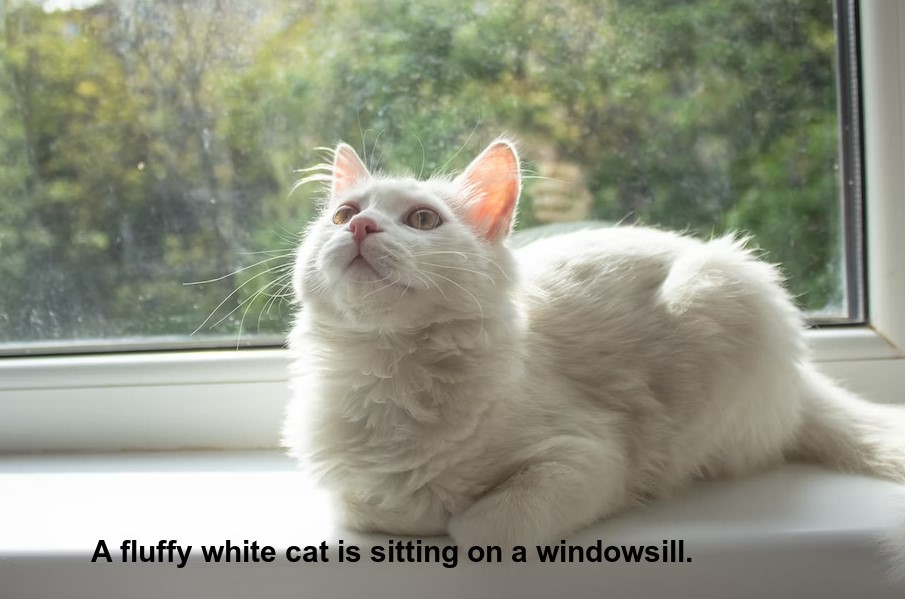

## How It Works

Think of Image Captioning as a collaboration between two essential components of the computer's brain:

1. **The Eye (Convolutional Neural Networks - CNNs):**
   Just as we have eyes to see, computers have CNNs to analyze pictures. These networks help the computer identify important elements in the image, such as the cat's ears or tail. These key elements are translated into a special set of numbers that the computer understands. These special numbers are called "vector embeddings."

2. **The Mouth (Recurrent Neural Networks - RNNs):**
   The computer's "mouth" is the RNN. It takes those special numbers (vector embeddings) from the CNN and combines them with the power of words. It's as if we're teaching the computer to narrate a story about the image. The RNN takes one word at a time and starts forming a sentence. It begins with "Fluffy," followed by "white," and so on, until a complete description is created.

## Why It's Fascinating

Image Captioning empowers computers to describe images just like humans do. This enhances computers' image understanding capabilities and enables them to communicate using descriptive language. If you're curious to see how this collaboration looks in visual representation, check out the Modelling section!


# Import necessary modules

In [4]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu
print("importing files are working succesfully")

importing files are working succesfully


In [5]:
# Setting the input and output directory
INPUT_DIR = r'E:\DL\image-caption-generator\flickr8k'
OUTPUT_DIR = r'E:\DL\image-caption-generator'

# Image Features Extraction

When it comes to understanding images, we need a helping hand from specialized models. Here's where the pre-trained VGG16 model steps in. This model is like a superhero for extracting important details from images, helping us understand what's happening.

![fluffy-cat.jpg](https://www.researchgate.net/publication/353925876/figure/fig2/AS:1057413557915648@1629118446024/Example-of-feature-extraction-using-a-VGG16-A-represents-the-input-layer-of-VGG16-224.ppm)

## Why VGG16?

VGG16 is popular because it has a knack for extracting both simple and complex features from images. Think of it as an image interpreter. It can tell us about the cat's pointy ears, its fluffy fur, and even the windowsill it's sitting on.

With the image features extracted by VGG16, we'll be able to merge the world of images and words, creating meaningful captions that describe the pictures as if the computer were telling a story.

So, let's harness the power of VGG16 for our image feature extraction!

In [8]:
# We are going to use pretrained VGG16 model
# Load the VGG16 model
model = VGG16()

# Restructure the model to remove the last classification layer, giving access to the output features
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Print the model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for idx, img_name in enumerate(tqdm(os.listdir(img_dir))):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for VGG16
    image = preprocess_input(image)   
    # Extract features using the pre-trained VGG16 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature
    # Print progress every 500 images
    if idx % 500 == 0 and idx != 0:
        print(f"Processed {idx} images out of {len(os.listdir(img_dir))}")

  0%|          | 0/8084 [00:00<?, ?it/s]

Processed 500 images out of 8084


In [6]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

NameError: name 'image_features' is not defined

In [7]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

# Loading Caption Data

In [8]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [9]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


In [10]:
# Filter image_to_captions_mapping to only include images with features
image_to_captions_mapping = {k: v for k, v in image_to_captions_mapping.items() if k in loaded_features}

#### So there are total 40455 captions for 8091 images that's means there are 5 captions for each image

# Preprocessing Captions: Getting Them Ready

Before we dive into the exciting world of creating captions for images, we need to prepare our captions so that our models can understand them. This process is known as preprocessing.

In [11]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq** ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' **endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [13]:
# preprocess the text
clean(image_to_captions_mapping)

In [14]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq** black dog carries green toy in his mouth as he walks through the grass **endseq',
 'startseq** black dog carrying something through the grass **endseq',
 'startseq** black dog has blue toy in its mouth **endseq',
 'startseq** dog in grass with blue item in his mouth **endseq',
 'startseq** wet black dog is carrying green toy through the grass **endseq']

In [15]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [16]:
all_captions[:10]

['startseq** dog shakes its head near the shore red ball next to it **endseq',
 'startseq** white dog shakes on the edge of beach with an orange ball **endseq',
 'startseq** dog with orange ball at feet stands on shore shaking off water **endseq',
 'startseq** white dog playing with red ball on the shore near the water **endseq',
 'startseq** white dog with brown ears standing near water with head turned to one side **endseq',
 'startseq** boy smiles in front of stony wall in city **endseq',
 'startseq** little boy is standing on the street while man in overalls is working on stone wall **endseq',
 'startseq** young boy runs aross the street **endseq',
 'startseq** young child is walking on stone paved street with metal pole and man behind him **endseq',
 'startseq** smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him **endseq']

In [17]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [18]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [19]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8765
Maximum Caption Length: 34


# Train Test Split

In [20]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# Filter out image IDs not present in loaded_features
train = [img_id for img_id in train if img_id in loaded_features]
test = [img_id for img_id in test if img_id in loaded_features]

# Optionally, print missing IDs for debugging
missing_train = [img_id for img_id in train if img_id not in loaded_features]
missing_test = [img_id for img_id in test if img_id not in loaded_features]
print("Missing in train:", missing_train)
print("Missing in test:", missing_test)

Missing in train: []
Missing in test: []


In [22]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    X1_batch, X2_batch, y_batch = [], [], []
    batch_count = 0

    while True:
        for image_id in data_keys:
            # Defensive check: skip if image_id not in features
            if image_id not in features:
                continue
            captions = image_to_captions_mapping[image_id]
            for caption in captions:
                caption_seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(caption_seq)):
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1_batch.append(features[image_id][0])
                    X2_batch.append(in_seq)
                    y_batch.append(out_seq)
                    batch_count += 1
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield (X1_batch, X2_batch), y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# LSTM Model Training

We've got our image features, and we're ready to make our captions come to life. In this section, we'll be diving into the training of our LSTM model. This is where the real magic happens as we teach our model to generate descriptive captions for our images.

![LSTM-Architecture](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

In [23]:
%pip install graphviz
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model, show_shapes=True)




You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [24]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
              validation_data=test_generator, validation_steps=validation_steps,
              verbose=1)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 78s 287ms/step - loss: 6.4214 - val_loss: 6.3033
228/228 ━━━━━━━━━━━━━━━━━━━━ 78s 287ms/step - loss: 6.4214 - val_loss: 6.3033
Epoch 2/50
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 5.2106 - val_loss: 6.1703
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 5.2106 - val_loss: 6.1703
Epoch 3/50
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 270ms/step - loss: 4.8105 - val_loss: 6.5641
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 270ms/step - loss: 4.8105 - val_loss: 6.5641
Epoch 4/50
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 4.4912 - val_loss: 6.7197
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - loss: 4.4912 - val_loss: 6.7197
Epoch 5/50
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 4.2391 - val_loss: 7.0515
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 271ms/step - loss: 4.2391 - val_loss: 7.0515
Epoch 6/50
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 3.9668 - val_loss: 7.1328
228/228 ━━━━━━━━━━━━━

In [25]:
model.save(OUTPUT_DIR+'/mymodel.h5')

In [26]:
model.save(OUTPUT_DIR+'/mymodel.keras')

# Captions Generation

In [27]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [28]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [29]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/809 [00:00<?, ?it/s]

BLEU-1: 0.270090
BLEU-2: 0.123177
BLEU-2: 0.123177


# Predicting captions for Images

In [2]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq** man in hat is displaying pictures next to skier in blue hat **endseq
startseq** man skis past another man displaying paintings in the snow **endseq
startseq** person wearing skis looking at framed pictures set up in the snow **endseq
startseq** skier looks at framed pictures in the snow next to trees **endseq
startseq** man on skis looking at artwork for sale in the snow **endseq
--------------------Predicted--------------------
startseq man skis past another man displaying paintings in the snow endseq
--------------------Predicted--------------------
startseq man skis past another man displaying paintings in the snow endseq


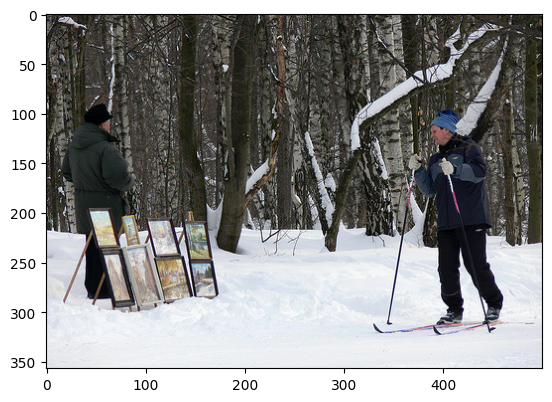

In [31]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq** man is standing in front of skyscraper **endseq
startseq** man stands in front of skyscraper **endseq
startseq** man stands in front of very tall building **endseq
startseq** behind the man in red shirt stands large skyscraper **endseq
startseq** there is skyscraper in the distance with man walking in front of the camera **endseq
--------------------Predicted--------------------
startseq man stands in front of skyscraper endseq
--------------------Predicted--------------------
startseq man stands in front of skyscraper endseq


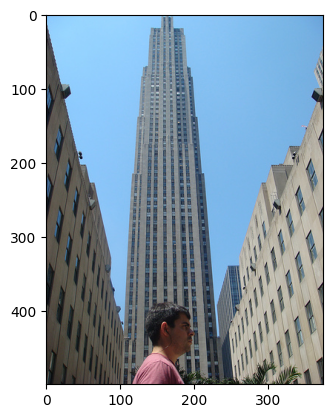

In [32]:
generate_caption("1032460886_4a598ed535.jpg")

In [3]:
generate_caption("10815824_2997e03d76.jpg")

NameError: name 'os' is not defined